In [1]:
%matplotlib inline

from Regression_Class import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('seaborn')



#%%writefile Regression_Class.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Regressor:
    
    def __init__(self,
                 target = None,
                 l_rate = .5,
                 stop = 1e-3,
                 reg_rate = 0.,
                 beta = .5,
                 epochs = 1000,
                 logistic=True):
        
        self.target = target
        self.l_rate = l_rate
        self.stop = stop
        self.reg_rate = reg_rate
        self.beta = beta
        self.epochs = epochs
        self.logistic = logistic
        self.start = None
        
    
                   
    def matrix(self, dataset):
        
        X = dataset.drop(self.target, axis=1).to_numpy()
        X = np.insert(X, 0, 1, axis=1)
        y = dataset[[self.target]].to_numpy()

        return X, y   
    

 
    def split(self, dataset, cutoff = .8):
        
        n = len(dataset)
        
        df_train, df_test = dataset.iloc[0:int(n*cutoff)], dataset.iloc[int(n*cutoff):]
        
        X_train, y_train = self.matrix(df_train)
        X_test, y_test = self.matrix(df_test)
          
        return  X_train, y_train, X_test, y_test
    
   
    
    def fit(self, X, y, graph = False):
        
        n = len(X)
        
        np.random.seed(3479)
        weights = np.random.rand(1, X.shape[1]) if self.start is None else self.start
    
        Gamma = np.full((1, X.shape[1]), self.reg_rate/n)
        Gamma[0, 0] = 0
    
        W_list = [weights]
        for i in range(self.epochs):
            H = X @ weights.T
            H = 1 / (1 + np.exp(-H)) if self.logistic else H
 
            dJ = (1/n) * ((H-y).T @ X)
            update = weights - (self.l_rate * dJ)

            soft_thresholding = lambda W, K: np.sign(W) * np.maximum(abs(W)-K, 0)
            shrinkage = 1 / (1 + self.l_rate*(1-self.beta)*Gamma)
            _weights = shrinkage * soft_thresholding(update, self.l_rate*self.beta*Gamma)
            
            W_list.append(_weights)
        
            delta = weights - _weights
            weights = _weights
        
            if (abs(delta) <= self.stop).all():
                break
        else:
            print('max epochs reached')
    
        W_list = np.array(W_list) 
    
        self.weights = weights
        self.start = weights
  
        if graph:
            plt.figure(figsize=(15, 10))
            for i in range(W_list.shape[2]):
                plt.plot(W_list[...,i], label=f'W_{i}')
            plt.legend(ncol=3, frameon=True, loc='upper right')
            plt.title(f'WEIGHTS\' EVOLUTION with lambda = {self.reg_rate}', fontsize=15)
            plt.xlabel('epochs', fontsize=13)
            plt.ylabel('parameters\' values', fontsize=13)
            plt.savefig('C:\\Users\\wince\\Desktop\\param.png')
            plt.show()

        return self
    
 
    
    def predict(self, test):
    
        self.prediction =  1 / (1 + np.exp(-(test @ self.weights.T)))
        
        return self
    

    
    def fit_predict(self, X_train, y_train, X_test):
        
        weights = self.fit(X_train, y_train, graph=False)
        prediction = 1 / (1 + np.exp(-(X_test @ self.weights.T)))
        
        return  weights, output
    
    
    
    def _metrics(self, test, threshold = 0.5):
            
        classification = np.array((self.prediction >= threshold), dtype=np.int)
    
        TP = len(classification[(classification == 1) & (classification == test)])
        FP = len(classification[(classification == 1) & (classification != test)])
        TN = len(classification[(classification == 0) & (classification == test)])
        FN = len(classification[(classification == 0) & (classification != test)])

        epsilon = 1e-7
        self.accuracy = (TP+TN) / (TP+TN+FP+FN)
        self.precision = TP / (TP+FP+epsilon)
        self.recall = TP / (TP+FN+epsilon)
        self.F1 = (2*self.precision*self.recall) / (self.precision+self.recall+epsilon) 

        self.confusion_matrix = np.array([[TP, FP], [TN, FN]])
            
        return self.confusion_matrix
    

 
    def metrics(self, test, threshold = 0.5):
        
        self._metrics(test, threshold)
        
        print(f'Accuracy: {self.accuracy}\nPrecision: {self.precision}\nRecall: {self.recall}\nF1 score: {self.F1}', end='\n\n')
        print(f'Confusion Matrix:\n {self.confusion_matrix}')
            


    def ROC(self, test):
        
        results = (self._metrics(test, i).reshape(4) for i in np.arange(0.0, 1.1, 0.01))
        TP, FP, TN, FN = zip(*results)
    
        epsilon = 1e-7
        TPR = np.array(TP) / (np.array(TP) + np.array(FN) + epsilon)
        FPR = np.array(FP) / (np.array(FP) + np.array(TN) + epsilon)
    
        AUC = np.around(np.trapz(TPR, FPR), 2)
    
        plt.figure(figsize=(8, 8))
        plt.plot(FPR, TPR, color='b')
        plt.plot([0,1], [0,1], 'r--')
        plt.text(0.7, 0.2, f'AUC = {abs(AUC)}', fontsize=16, color='k')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC', fontsize=15)
        plt.show()
        

        
    def cross_val(self, istance, dataset, folds = 10, threshold = 0.5):
        
        #dataset.sample(frac=1).reset_index(drop=True)
        reg_CV = Regressor(
            target=istance.target,
            l_rate=istance.l_rate,
            stop=istance.stop,
            reg_rate=istance.reg_rate,
            beta=istance.beta,
            epochs=istance.epochs,
            logistic=istance.logistic)
        
        assert folds > 1, 'folds must be greater than 1'
        
        slices = np.arange(0, len(dataset)+1, len(dataset)//folds)
        df_train = (dataset.drop(index=range(slices[i], slices[i+1])) for i in range(folds))
        df_test = (dataset.iloc[slices[i]:slices[i+1]] for i in range(folds))
        
        train = map(reg_CV.matrix, df_train)
        test = map(reg_CV.matrix, df_test)

        results = sum([reg_CV.fit(a, b).predict(c)._metrics(d, threshold) for (a, b), (c, d) in zip(train, test)])
        (TP, FP), (TN, FN) = results
    
        epsilon = 1e-7
        a = (TP+TN) / (TP+TN+FP+FN)
        p = TP / (TP+FP+epsilon)
        r = TP / (TP+FN+epsilon)
        F1 = (2*p*r) / (p+r)
    
        confusion_matrix = np.array([[TP, FP], [TN, FN]])
    
        print(f'Accuracy: {a}\nPrecision: {p}\nRecall: {r}\nF1 score: {F1}\n\nConfusion Matrix:\n {confusion_matrix}')

In [2]:
df = pd.read_csv(
    "C:\\Users\\wince\\Google Drive\\DATA SCIENCE\\LEZIONI\\ML\\Polignano\\01.REGRESSION\\DataEx_LinRegression\\heart.arff.csv",
    delimiter=',')

In [3]:
df.shape

(303, 14)

In [4]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


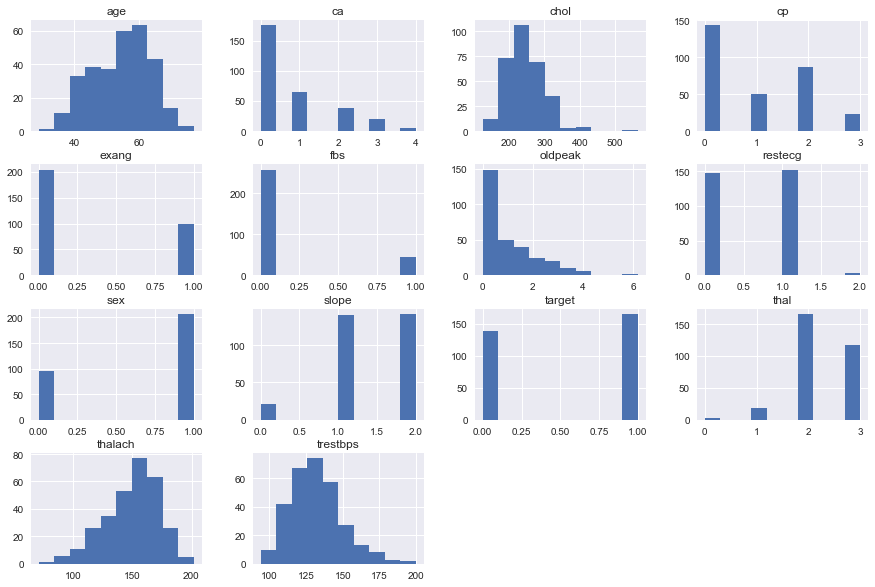

In [6]:
ax = df.hist(bins=10, figsize=(15, 10))

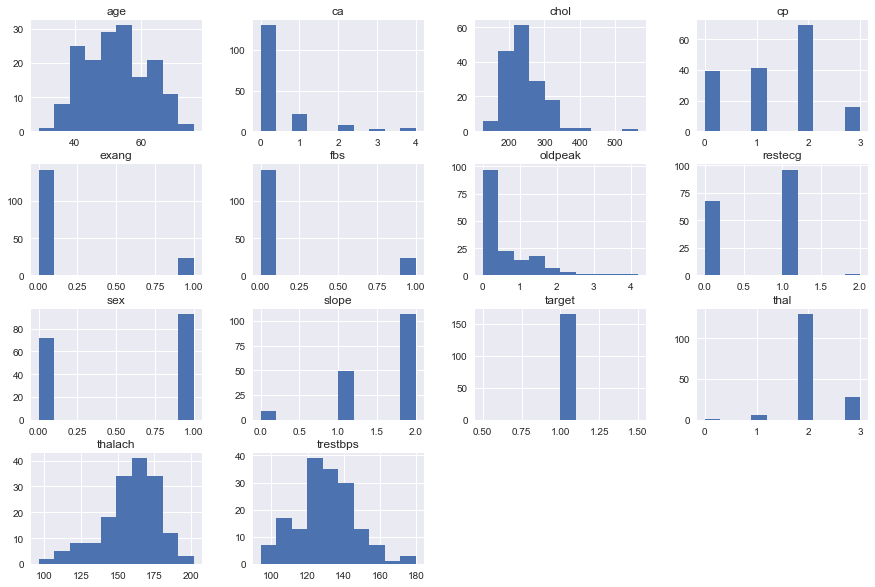

In [7]:
ax = df.query('target == 1').hist(bins=10, figsize=(15, 10))

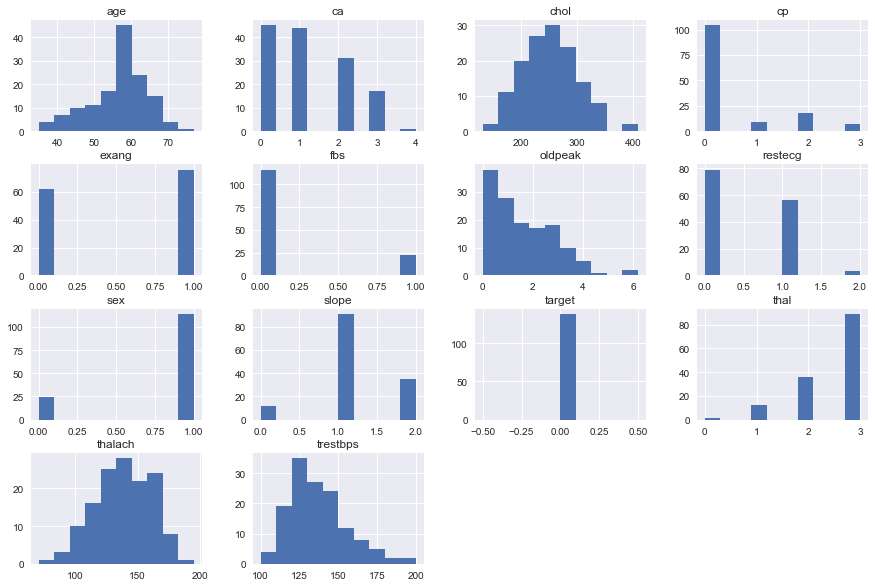

In [8]:
ax = df.query('target == 0').hist(bins=10, figsize=(15, 10))

In [9]:
df.groupby(['sex']).target.size().to_frame()

,target
sex,
0,96
1,207


In [10]:
df.groupby(['target']).ca.size().to_frame()

,ca
target,
0,138
1,165


In [11]:
num_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
ord_columns = []
#ord_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']
cat_columns = [col for col in df.columns if col not in (num_columns + ord_columns)]
cat_columns

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [12]:
df[cat_columns] = df[cat_columns].astype('category')

In [13]:
df[num_columns] = df[num_columns].transform(lambda x: (x-x.mean())/x.std())

In [14]:
#df[ord_columns] = df[ord_columns].transform(lambda x: (x-x.min())/(x.max()-x.min()))

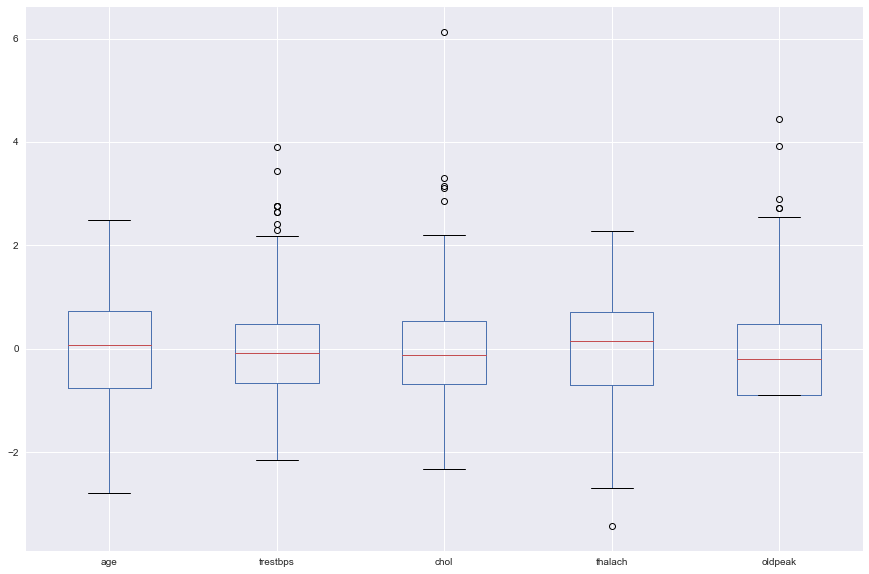

In [15]:
ax = df.plot.box(figsize=(15, 10))

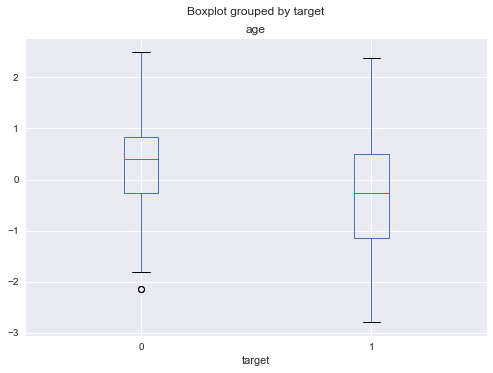

In [16]:
df.boxplot(column='age', by='target')

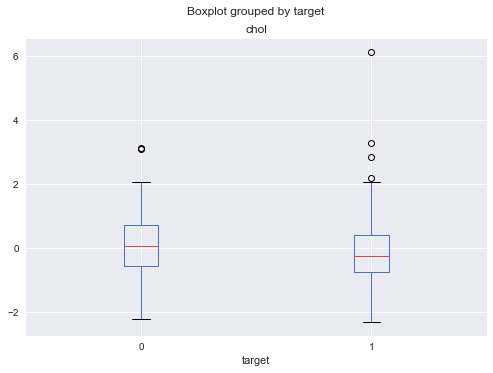

In [17]:
df.boxplot(column='chol', by='target')

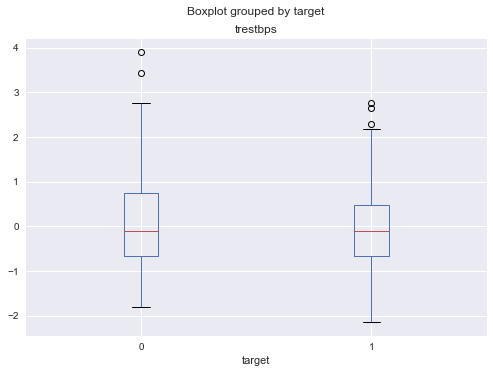

In [18]:
df.boxplot(column='trestbps', by='target')

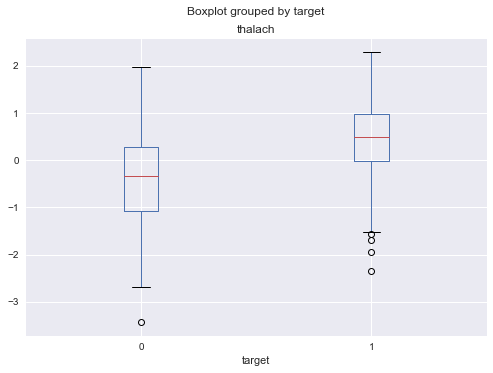

In [19]:
df.boxplot(column='thalach', by='target')

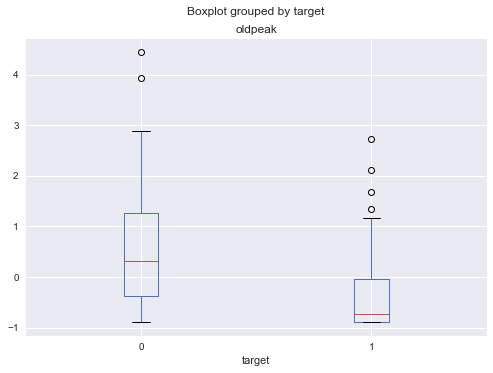

In [20]:
df.boxplot(column='oldpeak', by='target')

In [21]:
df1 = pd.get_dummies(df, sparse=False, drop_first=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.950624,1,3,0.762694,-0.255910,1,0,0.015417,0,1.085542,0,0,1,1
1,-1.912150,1,2,-0.092585,0.072080,0,1,1.630774,0,2.119067,0,0,2,1
2,-1.471723,0,1,-0.092585,-0.815424,0,0,0.975900,0,0.310399,2,0,2,1
3,0.179877,1,1,-0.662770,-0.198030,0,1,1.237849,0,-0.206364,2,0,2,1
4,0.289984,0,0,-0.662770,2.078611,0,1,0.582975,1,-0.378618,2,0,2,1


In [22]:
df_mix = df1.sample(frac=1, random_state=3479).reset_index(drop=True)
df_mix.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
0,1.060731,-0.092585,1.094639,-1.207015,0.827161,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,0.289984,-1.232956,1.712033,-0.290191,1.688432,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,-0.370656,-0.092585,0.187842,-0.028241,-0.464745,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
3,-2.242470,-0.776808,-0.699662,1.849065,-0.292491,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,0.620304,0.762694,0.689474,-0.333849,1.516178,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [23]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float64
 1   trestbps   303 non-null    float64
 2   chol       303 non-null    float64
 3   thalach    303 non-null    float64
 4   oldpeak    303 non-null    float64
 5   sex_1      303 non-null    uint8  
 6   cp_1       303 non-null    uint8  
 7   cp_2       303 non-null    uint8  
 8   cp_3       303 non-null    uint8  
 9   fbs_1      303 non-null    uint8  
 10  restecg_1  303 non-null    uint8  
 11  restecg_2  303 non-null    uint8  
 12  exang_1    303 non-null    uint8  
 13  slope_1    303 non-null    uint8  
 14  slope_2    303 non-null    uint8  
 15  ca_1       303 non-null    uint8  
 16  ca_2       303 non-null    uint8  
 17  ca_3       303 non-null    uint8  
 18  ca_4       303 non-null    uint8  
 19  thal_1     303 non-null    uint8  
 20  thal_2    

In [24]:
log_reg = Regressor(target='target_1', l_rate=.3, reg_rate=1, beta=1)

In [25]:
X_train, y_train, X_test, y_test = log_reg.split(df_mix, cutoff=.8)

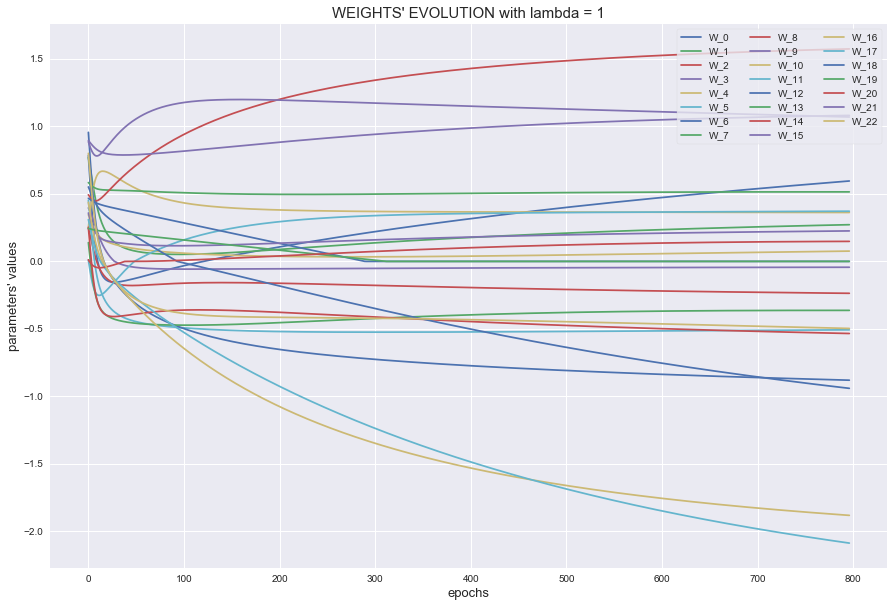

In [26]:
log_reg.fit(X_train, y_train, graph=True).predict(X_test);

In [27]:
features = np.insert(df_mix.columns.to_numpy()[:-1], 0, 'bias')
weights = pd.DataFrame({'features': features, 'weights': log_reg.weights.reshape(log_reg.weights.shape[-1])})
weights

,features,weights
0,bias,0.595549
1,age,0.271843
2,trestbps,-0.236284
3,chol,-0.043365
4,thalach,0.362174
5,oldpeak,-0.506905
6,sex_1,-0.879917
7,cp_1,0.514865
8,cp_2,1.573853
9,cp_3,1.081179


In [28]:
log_reg.metrics(y_test)

Accuracy: 0.8524590163934426
Precision: 0.8684210503462604
Recall: 0.8918918894813732
F1 score: 0.879999947662225

Confusion Matrix:
 [[33  5]
 [19  4]]


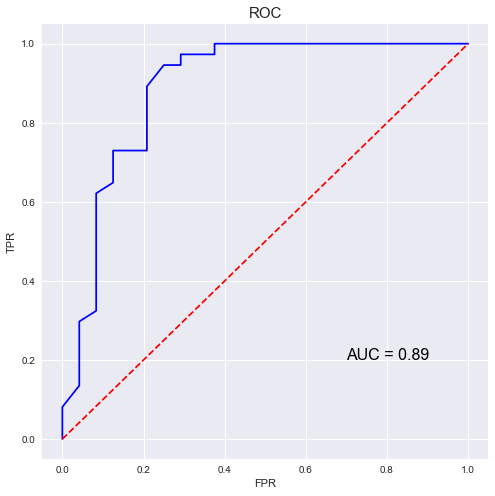

In [29]:
log_reg.ROC(y_test)

In [37]:
log_reg.cross_val(log_reg, df_mix, folds=len(df_mix))

Accuracy: 0.8745874587458746
Precision: 0.8587570616617192
Recall: 0.9212121206538109
F1 score: 0.8888888883690708

Confusion Matrix:
 [[152  25]
 [113  13]]


In [31]:
X_mix, y_mix, _, _ = log_reg.split(df_mix, cutoff=1.)

In [32]:
log_reg.predict(X_mix).metrics(y_mix)

Accuracy: 0.8679867986798679
Precision: 0.8698224846924127
Recall: 0.890909090369146
F1 score: 0.8802394704381684

Confusion Matrix:
 [[147  22]
 [116  18]]


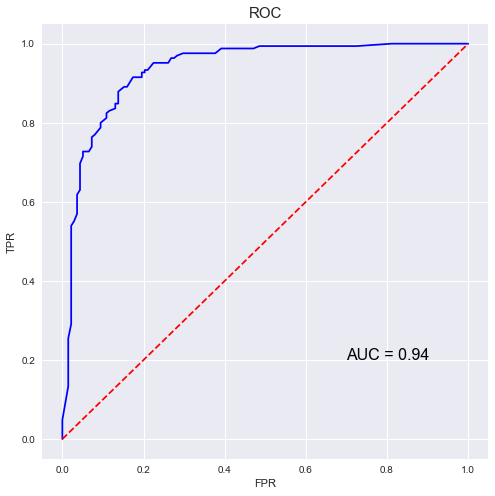

In [33]:
log_reg.ROC(y_mix)